# House Prices

コンペのURL：https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

## ①データの分析

データを読み込んで、データの内容を確認

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

## ②とりあえず一回提出してみる

まずはどのくらいの精度が出るのか確かめる。数字の要素だけで解いてみる。

In [5]:
linear_train = train_data.copy()
linear_test = test_data.copy()

In [6]:
linear_columns = pd.concat([linear_train,linear_test]).select_dtypes(include=[int,float]).dropna(how='any',axis=1).columns.values

In [7]:
linear_test = linear_test.filter(items=linear_columns)
linear_columns = np.append(linear_columns,'SalePrice')
linear_train = linear_train.filter(items=linear_columns)

モデルを学習＆実行

In [8]:
linear_model = LinearRegression()
X_train = linear_train.drop(columns='SalePrice')
y_train = linear_train['SalePrice']
linear_model.fit(X_train,y_train)

LinearRegression()

In [9]:
linear_prd = linear_model.predict(linear_test)

提出してみる

In [10]:
pd.DataFrame(data=linear_prd, columns=['SalePrice'],index=range(1461,2920)).to_csv('linear.csv')

提出スコア：0.34046

## ③特徴量エンジニアリング

### 3.1データを眺めてみる

In [11]:
new_train = train_data.copy()
new_test = test_data.copy()

データサイズの確認、データ数があまり多くないことがわかった

In [12]:
print("訓練データ",new_train.shape)
print("テストデータ",new_test.shape)

訓練データ (1460, 81)
テストデータ (1459, 80)


目的変数のばらつきを確認、右裾が長い＝豪邸がいくつかある？

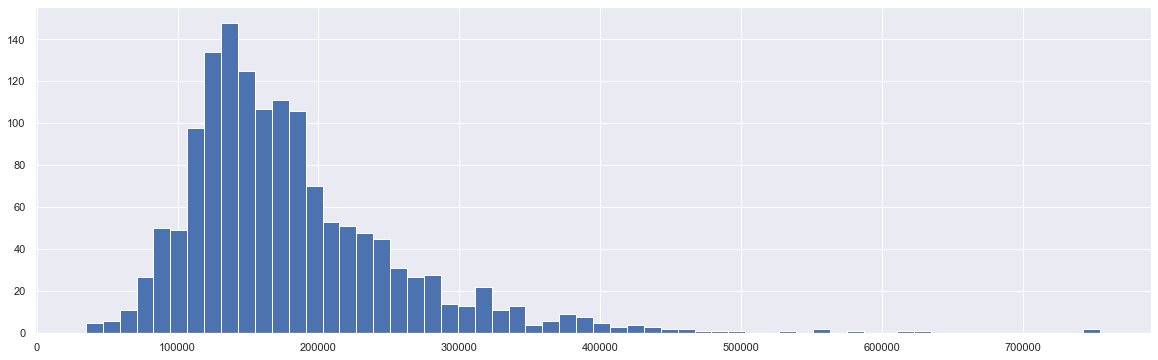

In [13]:
plt.figure(figsize=(20,6))
plt.hist(new_train['SalePrice'],bins=60)
plt.grid(True)

目的変数を正規分布にするために、logをかけて後で修正

In [14]:
new_train['SalePrice']=np.log(new_train['SalePrice'])

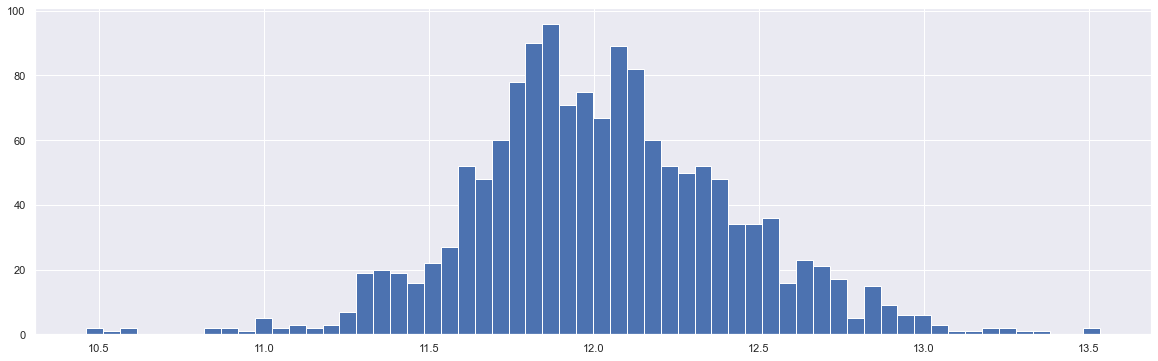

In [15]:
plt.figure(figsize=(20,6))
plt.hist(new_train['SalePrice'],bins=60)
plt.grid(True)

SalePriceと相関が強そうなデータを探して可視化する（データ型が数値、Boolのみ対象）

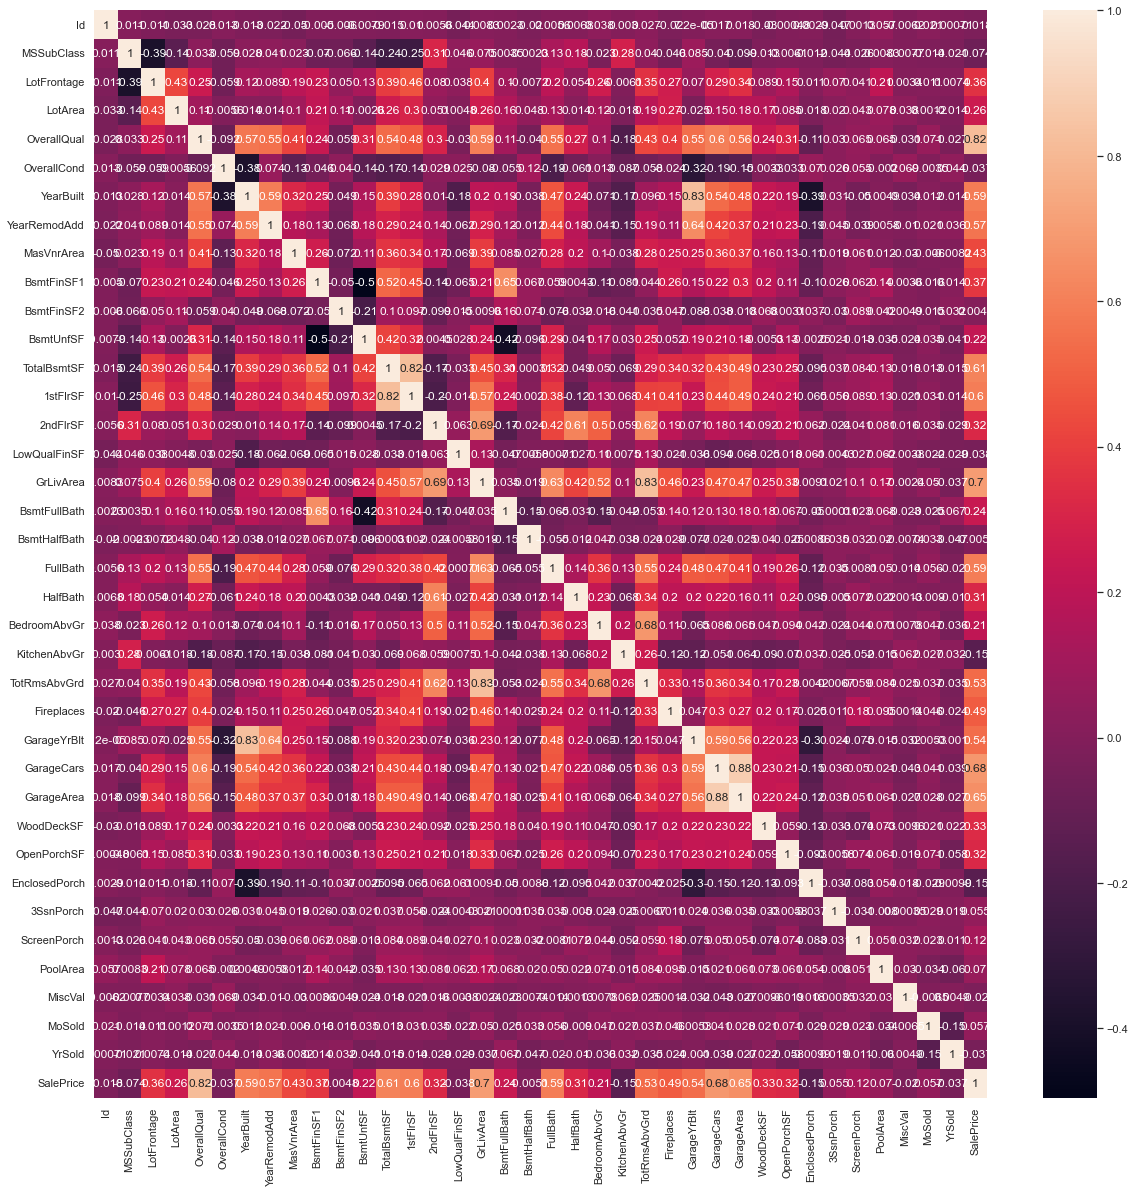

In [16]:
corr_data = new_train.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_data, annot=True)
plt.show()

ヒートマップで見ても分かりにくいので、相関係数が大きいものと小さいものを抽出

In [17]:
corr_indexes = new_train.corr()

In [18]:
corr_indexes['SalePrice'].sort_values()

EnclosedPorch   -0.149050
KitchenAbvGr    -0.147548
MSSubClass      -0.073959
LowQualFinSF    -0.037963
YrSold          -0.037263
OverallCond     -0.036868
MiscVal         -0.020021
Id              -0.017942
BsmtHalfBath    -0.005149
BsmtFinSF2       0.004832
3SsnPorch        0.054900
MoSold           0.057329
PoolArea         0.069798
ScreenPorch      0.121208
BedroomAbvGr     0.209044
BsmtUnfSF        0.221985
BsmtFullBath     0.236224
LotArea          0.257320
HalfBath         0.313982
2ndFlrSF         0.319300
OpenPorchSF      0.321053
WoodDeckSF       0.334135
LotFrontage      0.355878
BsmtFinSF1       0.372023
MasVnrArea       0.430809
Fireplaces       0.489449
TotRmsAbvGrd     0.534422
GarageYrBlt      0.541073
YearRemodAdd     0.565608
YearBuilt        0.586570
FullBath         0.594771
1stFlrSF         0.596981
TotalBsmtSF      0.612134
GarageArea       0.650888
GarageCars       0.680625
GrLivArea        0.700927
OverallQual      0.817184
SalePrice        1.000000
Name: SalePr

### 3.2 欠損値への対応

どのくらい欠損しているのかを調べる

In [19]:
nan_indexes = new_train.isnull().sum()
nan_indexes[nan_indexes!=0].sort_values()/1460

Electrical      0.000685
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtExposure    0.026027
BsmtFinType2    0.026027
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
GarageYrBlt     0.055479
LotFrontage     0.177397
FireplaceQu     0.472603
Fence           0.807534
Alley           0.937671
MiscFeature     0.963014
PoolQC          0.995205
dtype: float64

**欠損が大きいデータ６つに関して、そのデータがどのようなものかを見ていく**  
LotFrontage...物件に接続している道路の直線距離  
FireplaceQu...暖炉の種類  
Fence...フェンスのグレード  
Alley...敷地内にある路地の種類  
MiscFeature...エレベーターなど特別なものがついているか否か  
PoolQC...プールのグレード  
→PoolQC,MiscFeature,Alley,Fenceは大事そう＝NaNか否かという特徴量に作り替える  
→それ以外のデータは数も多いので最頻値で補填（new_testのみにある欠損も同様）

In [20]:
for item in ["Electrical","MasVnrType","MasVnrArea","BsmtQual","BsmtCond","BsmtFinType1","BsmtExposure","BsmtFinType2","GarageCond","GarageQual","GarageFinish","GarageType","GarageYrBlt" ,"LotFrontage","FireplaceQu",
"Exterior1st","Exterior2nd", "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","KitchenQual","GarageCars","GarageArea","SaleType","Utilities","BsmtFullBath","BsmtHalfBath","Functional","MSZoning" ]:
    new_test[item] = new_test[item].fillna(new_train[item].mode()[0])
    new_train[item] = new_train[item].fillna(new_train[item].mode()[0])

In [21]:
for item in ["Fence","Alley","MiscFeature","PoolQC"]:
    new_train[item] = new_train[item].where(new_train[item] != None,True)
    new_train[item] = new_train[item].fillna(False)
    new_test[item] = new_test[item].where(new_test[item] != None,True)
    new_test[item] = new_test[item].fillna(False)

In [22]:
new_train.isnull().sum()[new_train.isnull().sum()!=0].sort_values()/1460
new_test.isnull().sum()[new_test.isnull().sum()!=0].sort_values()/1460

Series([], dtype: float64)

これで欠損は無くなった

### 3.3　数字ではないデータへの対応

文字ラベルをOne-hot表現にする

In [23]:
data_types = new_train.dtypes
data_indexes = new_train.columns
one_hot_indexes = []
for idx in range(len(data_types)):
    if data_types[idx] == 'object':
        one_hot_indexes.append(data_indexes[idx])

In [24]:
new_train = pd.get_dummies(new_train, columns=one_hot_indexes)
new_test = pd.get_dummies(new_test, columns=one_hot_indexes)

In [25]:
new_train.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=294)

### 3.4　特徴量の選別

特徴量の数が多いので、必要のない特徴量を削る  
単変量統計を用いた手法として、相互情報量を試してみる

In [26]:
train_X = new_train.copy()
train_y = train_X['SalePrice']
train_X = train_X.drop('SalePrice', axis=1)
mi = mutual_info_regression(train_X,train_y)

In [27]:
idx = np.argsort(mi)[::-1]
top_cols = train_X.columns.values[idx][:100]

In [28]:
 top_cols

array(['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
       'YearBuilt', 'GarageCars', '1stFlrSF', 'MSSubClass', 'FullBath',
       'ExterQual_TA', 'YearRemodAdd', 'GarageYrBlt', 'KitchenQual_TA',
       'TotRmsAbvGrd', 'ExterQual_Gd', 'GarageFinish_Unf', 'BsmtQual_TA',
       '2ndFlrSF', 'KitchenQual_Gd', 'Foundation_PConc', 'LotFrontage',
       'Fireplaces', 'LotArea', 'BsmtQual_Gd', 'OpenPorchSF',
       'BsmtFinSF1', 'HeatingQC_Ex', 'BsmtUnfSF', 'BsmtQual_Ex',
       'GarageFinish_Fin', 'OverallCond', 'BsmtFinType1_GLQ',
       'GarageType_Detchd', 'WoodDeckSF', 'Foundation_CBlock',
       'Exterior2nd_VinylSd', 'MasVnrArea', 'HeatingQC_TA',
       'KitchenQual_Ex', 'Exterior1st_VinylSd', 'LotShape_Reg',
       'GarageFinish_RFn', 'MasVnrType_None', 'HalfBath', 'SaleType_New',
       'MSZoning_RM', 'SaleCondition_Partial', 'Neighborhood_NAmes',
       'BedroomAbvGr', 'CentralAir_N', 'LotShape_IR1', 'CentralAir_Y',
       'Neighborhood_NridgHt', 'ExterQual_Ex', 'GarageTy

次に、ランダムフォレストで重要度を見てみる

In [29]:
clf = RandomForestRegressor(n_estimators=20,random_state=7)
clf.fit(train_X,train_y)
fi = clf.feature_importances_
idx = np.argsort(fi)[::-1]
top_cols,top_importances = train_X.columns.values[idx][:50],fi[idx][:50]

<BarContainer object of 50 artists>

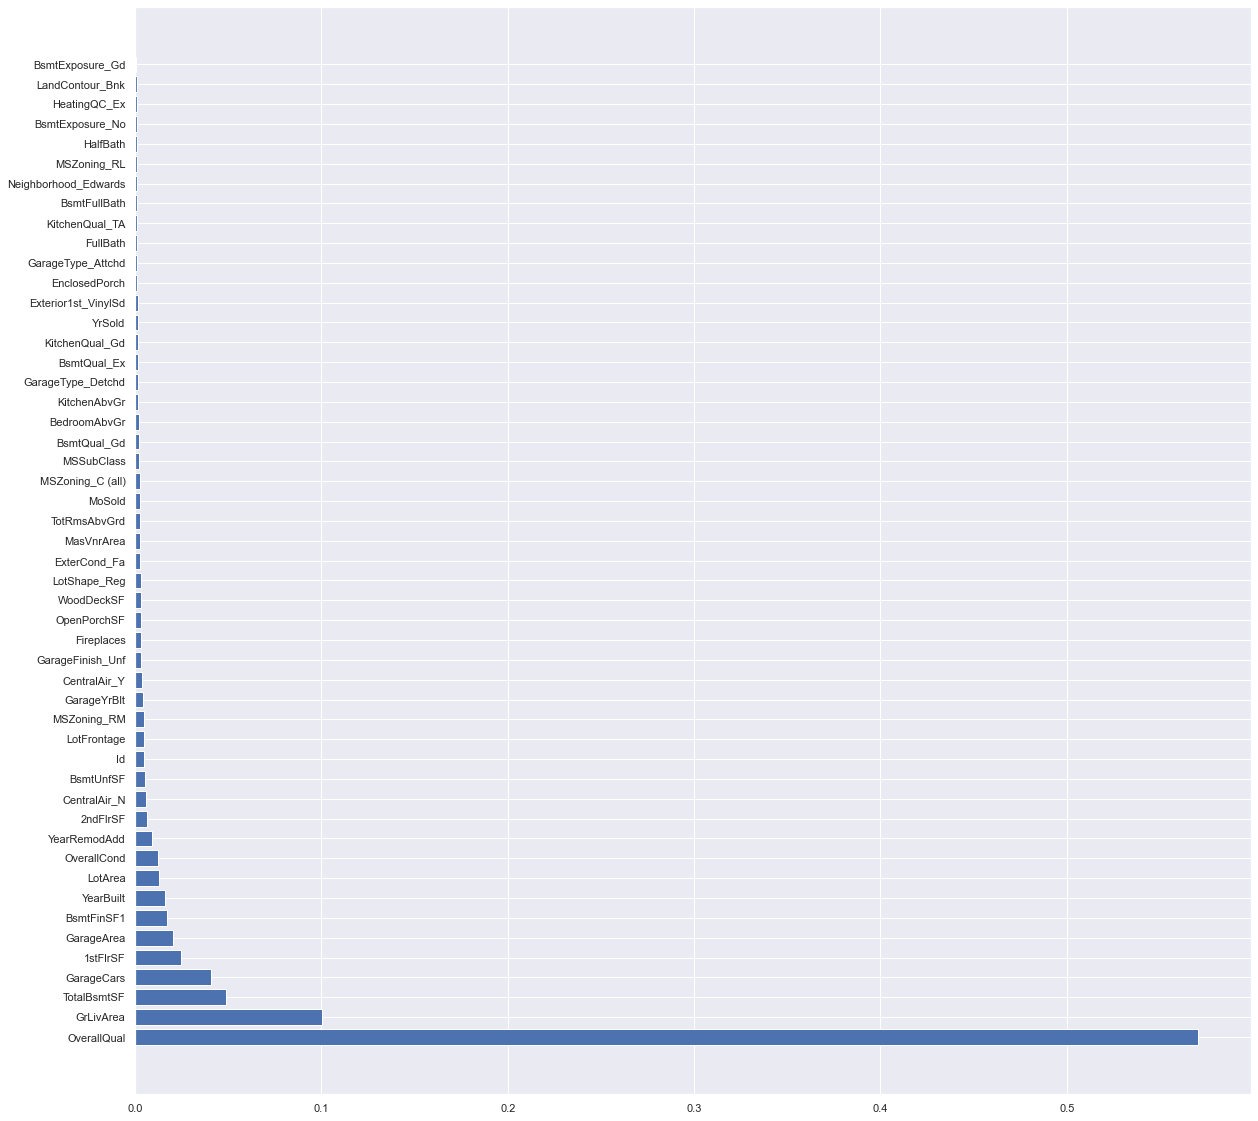

In [30]:
plt.figure(figsize=(20,20))
plt.barh(top_cols,top_importances)

これより、重要度が大きい順に8個と1４個の２パターンで特徴量を設定する

In [31]:
min_features= top_cols[:8]
max_features = top_cols[:14]

## ④学習

### 4.1 ラッソ回帰

#### 4.1.1　特徴量が８個

In [32]:
lasso_model1 = Lasso()
lasso_model1.fit(train_X[min_features],train_y)
lasso_prd1 = np.exp(lasso_model1.predict(new_test[min_features]))

In [33]:
pd.DataFrame(data=lasso_prd1, columns=['SalePrice'],index=range(1461,2920)).to_csv('lasso1.csv')

提出スコア：0.20521

#### 4.1.2　特徴量が１４個

In [34]:
lasso_model2 = Lasso()
lasso_model2.fit(train_X[max_features],train_y)
lasso_prd2 = np.exp(lasso_model2.predict(new_test[max_features]))

In [35]:
pd.DataFrame(data=lasso_prd2, columns=['SalePrice'],index=range(1461,2920)).to_csv('lasso2.csv')

提出スコア：0.19967

### 4.2 ランダムフォレスト（パラメーターチューニングなし）

#### 4.2.1　特徴量が８個

In [39]:
clf_model1 = RandomForestRegressor(n_estimators=5)
clf_model1.fit(train_X[min_features],train_y)
clf_prd1 = np.exp(lasso_model1.predict(new_test[min_features]))

In [40]:
pd.DataFrame(data=clf_prd1, columns=['SalePrice'],index=range(1461,2920)).to_csv('clf1.csv')

提出スコア: 0.20521

#### 4.2.1　特徴量が14個

In [41]:
clf_model2 = RandomForestRegressor(n_estimators=5)
clf_model2.fit(train_X[max_features],train_y)
clf_prd2 = np.exp(lasso_model2.predict(new_test[max_features]))

In [42]:
pd.DataFrame(data=clf_prd2, columns=['SalePrice'],index=range(1461,2920)).to_csv('clf2.csv')

提出スコア: 0.19967

### 4.3　4.1と4.2のアンサンブル

この４つの結果はさほど変わらないので、全ての結果に対して平均をとる

In [43]:
ens_prd = (lasso_prd1+lasso_prd2+clf_prd1+clf_prd2)/4

In [44]:
pd.DataFrame(data=ens_prd, columns=['SalePrice'],index=range(1461,2920)).to_csv('ens.csv')

提出スコア：0.20215